In [6]:
#!pip install alpha_vantage


In [2]:
from alpha_vantage.timeseries import TimeSeries
# Your key here
key = 'DXE06U7BMVFM3AGC'
ts = TimeSeries(key)
aapl, meta = ts.get_daily(symbol='AAPL')
print(aapl['2019-09-12'])

{'1. open': '224.8000', '2. high': '226.4200', '3. low': '222.8600', '4. close': '223.0900', '5. volume': '32226700'}


In [20]:
import json
symbol = 'GOOG'
data = ts.get_intraday(symbol,interval = '60min',outputsize='full')
data = data[0]
data

{'2019-10-25 15:30:00': {'1. open': '1264.5200',
  '2. high': '1266.0000',
  '3. low': '1263.5601',
  '4. close': '1265.0699',
  '5. volume': '194412'},
 '2019-10-25 14:30:00': {'1. open': '1263.7907',
  '2. high': '1266.2519',
  '3. low': '1263.3291',
  '4. close': '1264.2358',
  '5. volume': '198671'},
 '2019-10-25 13:30:00': {'1. open': '1266.9100',
  '2. high': '1268.4100',
  '3. low': '1263.1400',
  '4. close': '1263.7401',
  '5. volume': '88705'},
 '2019-10-25 12:30:00': {'1. open': '1266.6647',
  '2. high': '1267.8000',
  '3. low': '1265.4877',
  '4. close': '1266.8103',
  '5. volume': '64481'},
 '2019-10-25 11:30:00': {'1. open': '1267.9707',
  '2. high': '1270.6995',
  '3. low': '1265.3949',
  '4. close': '1266.3506',
  '5. volume': '111470'},
 '2019-10-25 10:30:00': {'1. open': '1261.9301',
  '2. high': '1269.4500',
  '3. low': '1261.5601',
  '4. close': '1267.9050',
  '5. volume': '197861'},
 '2019-10-25 09:30:00': {'1. open': '1251.0545',
  '2. high': '1263.5292',
  '3. low

In [35]:
sdata = {k:float(v['1. open']) for k,v in data.items()}
sdata

{'2019-10-25 15:30:00': 1264.52,
 '2019-10-25 14:30:00': 1263.7907,
 '2019-10-25 13:30:00': 1266.91,
 '2019-10-25 12:30:00': 1266.6647,
 '2019-10-25 11:30:00': 1267.9707,
 '2019-10-25 10:30:00': 1261.9301,
 '2019-10-25 09:30:00': 1251.0545,
 '2019-10-24 15:30:00': 1258.5,
 '2019-10-24 14:30:00': 1261.47,
 '2019-10-24 13:30:00': 1260.8107,
 '2019-10-24 12:30:00': 1257.865,
 '2019-10-24 11:30:00': 1262.0654,
 '2019-10-24 10:30:00': 1255.9369,
 '2019-10-24 09:30:00': 1260.9332,
 '2019-10-23 15:30:00': 1257.54,
 '2019-10-23 14:30:00': 1252.6278,
 '2019-10-23 13:30:00': 1253.3048,
 '2019-10-23 12:30:00': 1251.92,
 '2019-10-23 11:30:00': 1257.9868,
 '2019-10-23 10:30:00': 1256.7446,
 '2019-10-23 09:30:00': 1242.36,
 '2019-10-22 15:30:00': 1242.2924,
 '2019-10-22 14:30:00': 1246.5603,
 '2019-10-22 13:30:00': 1247.3999,
 '2019-10-22 12:30:00': 1245.6265,
 '2019-10-22 11:30:00': 1243.4861,
 '2019-10-22 10:30:00': 1247.66,
 '2019-10-22 09:30:00': 1247.2097,
 '2019-10-21 15:30:00': 1245.6274,
 '2

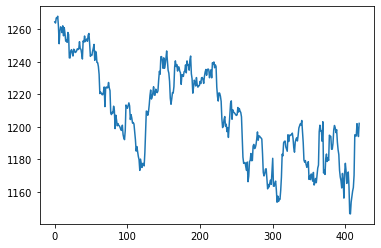

In [37]:
import matplotlib.pyplot as pp
pp.plot(list(sdata.values()))
pp.show()

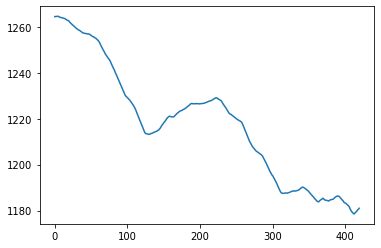

In [76]:
def smooth(values):
    beta = 0.98
    smoothed_vals = []
    prev = values[0]
    for v in values:
        moving_val = beta*prev + (1-beta)*v
        smoothed_vals.append(moving_val)
        prev = smoothed_vals[-1]
    return smoothed_vals

smoothed = smooth(list(sdata.values()))
pp.plot(smoothed)

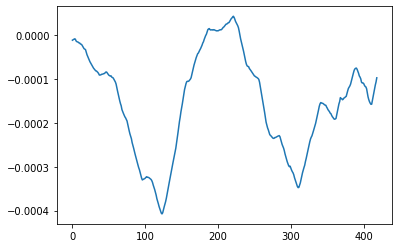

In [88]:
import math
def gradient(values):
    grads = []
    for i in range(len(values)-1):
        grad = (-values[i]+values[i+1])/values[i]
        grads.append(grad)
    return grads
grads = gradient(smoothed)
pp.plot(smooth(grads))

In [84]:
max_min = [i for i,v in enumerate(grads) where v = 0]


15.0

In [79]:
math.*?